# 1. basic

# 2. import libs

In [1]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from matplotlib import patches as patches
import cv2


In [2]:
import os
import shutil as sh

from pathlib import Path
import re
from tqdm import tqdm

import torch

import warnings 
warnings.simplefilter("ignore")

import seaborn as sns
import sys


In [3]:
sys.path.insert(0, "malaria/weightedboxesfusion/")
from ensemble_boxes import *


from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from sklearn.model_selection import train_test_split

import io
import base64

import time
from IPython.display import clear_output
from IPython.display import HTML

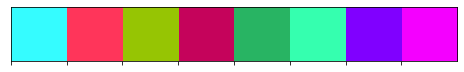

In [4]:
custom_colors = ['#35FCFF', '#FF355A', '#96C503', '#C5035B', '#28B463', '#35FFAF', '#8000FF', '#F400FF']
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
rgbcolors = list(map(hex2rgb, custom_colors))[1:]
sns.palplot(sns.color_palette(custom_colors))

In [5]:
def plot_data_example(df: pd.DataFrame,
                      root_dir: str,
                      img_path: str, 
                      colors: dict):

    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    boxes = np.zeros(image.shape, dtype="uint8")

    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(25, 8))
    ax[1].imshow(image, aspect="auto")
    ax[1].set_title("Original Image", fontsize=22, fontweight='bold', y=1.07)
    ax[0].set_title("Image with Bounding Boxes", fontsize=22, fontweight='bold', y=1.07)


    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]

        ax[0].add_patch(bbox)
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        ax[0].imshow(image, aspect="auto")
        ax[0].imshow(boxes,  alpha=0.3, aspect="auto")
        ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    fig.savefig("data_exemple1.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
    fig.savefig("data_exemple1.png", format='png', bbox_inches='tight', pad_inches=0.2)
    plt.show()


def plot_image_with_bb(df: pd.DataFrame,
                       root_dir: str,
                       img_path: str,
                       path_to_save: str, 
                       dpi: float=100, 
                       write: bool=True):
    
    image = cv2.imread(os.path.join(root_dir, img_path)).astype("uint8")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = np.zeros(image.shape, dtype="uint8")
    h, w, _ = image.shape
    figsize = (w / dpi), (h / dpi)

    fig, ax = plt.subplots(sharey=True, figsize=(figsize))
    fig.add_axes([0, 0, 1, 1])
 
    bb_info = df.loc[df["pathname"] == img_path, ["x_min", "x_max", "y_min", "y_max", "category"]].values
    for i_bb in bb_info:

        cmin, cmax, rmin, rmax = i_bb[:-1].astype('int')
        label = i_bb[-1]
        bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=1, 
                                 edgecolor=label2hex[label], facecolor='none')
        boxes[rmin:rmax, cmin:cmax] = label2rgb[label]
        ax = plt.gca()
        ax.add_patch(bbox)
        plt.text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))
        plt.imshow(image, aspect="auto")
        plt.imshow(boxes,  alpha=0.3, aspect="auto")
        plt.text(cmin, rmin, label, bbox=dict(fill=True, color=label2hex[label]))

    plt.tight_layout()
    #plt.axis("off")                                            ## dont work in kaggle kernel
    fig.axes[0].get_xaxis().set_visible(False)                  ## work in kaggle kernel
    fig.axes[0].get_yaxis().set_visible(False)

    if write:
        img_name = img_path.replace('/', '.').split('.')[-2]
        #fig.savefig(f"{path_to_save}/{img_name}.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
        fig.savefig(f"{path_to_save}/{img_name}.png", format='png', bbox_inches='tight', pad_inches=0.0)
        plt.close()
    else:
        plt.show()
  

def plot_sample(image: torch.Tensor,
                boxes: torch.Tensor, 
                labels: torch.Tensor):
    boxes = boxes.cpu().numpy().astype(np.int32)
    labels = labels.cpu().numpy().astype(np.int32)
    image = image.permute(1,2,0).cpu().numpy()
    image = (image * 255).astype(np.uint8)
    masks = np.zeros_like(image)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for label, box in zip(labels, boxes):
        color = label2rgb[label]
        text = label2category[label]
        cmin, rmin, cmax, rmax = box

        cv2.rectangle(image,
                    (cmin, rmin),
                    (cmax, rmax),
                    color=color, thickness=3,)
        cv2.putText(image, text, (cmin, rmin), cv2.FONT_HERSHEY_SIMPLEX, 1,  
                    color, 3, cv2.LINE_AA, False,) 
        
        masks[rmin:rmax, cmin:cmax] = color

    image_with_masks = cv2.addWeighted(image, 0.7, masks, 0.7, 0)
    ax.set_axis_off()
    ax.imshow(image_with_masks)

    
def create_video(path_to_imgs: str, video_name: str, framerate: int):
    """
    Create video from images.
    Params:
        path_to_imgs: path to dir with images.
        video_name: name for saving video.
        framerate: num frames per sec in video.
    """
    frame_width, frame_height = 1600, 1200
    img_names = sorted(os.listdir(path_to_imgs))
    img_path = os.path.join(path_to_imgs, img_names[0])

    fourc = cv2.VideoWriter_fourcc(*'XVID') 
    video = cv2.VideoWriter(video_name + ".avi", 
                            fourc, 
                            framerate, 
                            (frame_width, frame_height))

    for img_name in img_names:
        img_path = os.path.join(path_to_imgs, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (frame_width, frame_height))
        video.write(image)
            
    cv2.destroyAllWindows()
    video.release()
    
def show_video(video_path: str):
    """
    show video in jupyter notebook, agent interaction in environment.
    Takes - path to video file.
    Returns - html video player in jupyter notebook.
    """  
    video = io.open(video_path, 'r+b').read()
    encoded = base64.b64encode(video)

    return HTML(data='''<video alt="test" width="800" height="400" controls> 
    <source src="data:video/mp4;base64,{0}" type="video/mp4" /"> </video>'''
    .format(encoded.decode('ascii')))

In [6]:
class GlobalConfig:
        root_dir = 'malaria/'
        train_json_path = 'malaria/training.json'
        test_json_path = 'malaria/test.json'
        yolo_weights = 'malaria/yolov5x_malaria.pt'
        fasterrcnn_weights = 'malaria/fasterrcnn_resnet50_fpn.pth'
        seed = 33
def seed_everything(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    #torch.cuda.manual_seed(seed)

config = GlobalConfig()
seed_everything(config.seed)

# 3. Data Preparation

In [7]:
train_df = pd.read_json(config.train_json_path)
test_df = pd.read_json(config.test_json_path)
print(train_df.shape, test_df.shape)

(1208, 2) (120, 2)


In [8]:
train_df.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [9]:
df = pd.concat([train_df, test_df]).reset_index(drop=True)# 矩阵拼接
df.head()

,image,objects
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':..."
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ..."
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ..."
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ..."
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ..."


In [10]:
df.shape

(1328, 2)

In [11]:
print(df['image'].sample().values, "\n",#
      df['objects'].sample().values)

[{'checksum': 'e67761e9c465c2604242bbbad72ca7aa', 'pathname': '/images/1b7f47fc-26cd-4273-b848-88a7cbfd9f85.png', 'shape': {'r': 1200, 'c': 1600, 'channels': 3}}] 
 [list([{'bounding_box': {'minimum': {'r': 477, 'c': 549}, 'maximum': {'r': 578, 'c': 673}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 275, 'c': 908}, 'maximum': {'r': 391, 'c': 1024}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 177, 'c': 393}, 'maximum': {'r': 297, 'c': 514}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 975, 'c': 975}, 'maximum': {'r': 1101, 'c': 1108}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 275, 'c': 1089}, 'maximum': {'r': 379, 'c': 1222}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 848, 'c': 439}, 'maximum': {'r': 967, 'c': 557}}, 'category': 'red blood cell'}, {'bounding_box': {'minimum': {'r': 915, 'c': 1376}, 'maximum': {'r': 1036, 'c': 1497}}, 'category': 'red blood cell'}, {'boundi

In [12]:
# future: plot bounding box to display more details

In [13]:
df.shape

(1328, 2)

In [14]:
# 在 dataframe 种添加新的3列
df["checksum"] = df['image'].apply(lambda x: x["checksum"])
df["pathname"] = df['image'].apply(lambda x: x["pathname"][1:])
df["shape"] = df['image'].apply(lambda x: x["shape"])
df.head()

,image,objects,checksum,pathname,shape
0,{'checksum': '676bb8e86fc2dbf05dd97d51a64ac0af...,"[{'bounding_box': {'minimum': {'r': 1057, 'c':...",676bb8e86fc2dbf05dd97d51a64ac0af,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
1,{'checksum': '1225a18efce159eddf7b0e80e0ea642c...,"[{'bounding_box': {'minimum': {'r': 734, 'c': ...",1225a18efce159eddf7b0e80e0ea642c,images/10be6380-cbbb-4886-8b9e-ff56b1710576.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
2,{'checksum': '3eaf840523c30fdf38897ffa01e194eb...,"[{'bounding_box': {'minimum': {'r': 724, 'c': ...",3eaf840523c30fdf38897ffa01e194eb,images/6b14c855-8561-417c-97a4-63fa552842fd.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
3,{'checksum': '8a111dffacfa433029492780b9535091...,"[{'bounding_box': {'minimum': {'r': 563, 'c': ...",8a111dffacfa433029492780b9535091,images/13099edb-35d9-438f-b093-2cf2ebf9d255.png,"{'r': 1200, 'c': 1600, 'channels': 3}"
4,{'checksum': 'ccef403e971460b86444cca669e68ca1...,"[{'bounding_box': {'minimum': {'r': 618, 'c': ...",ccef403e971460b86444cca669e68ca1,images/2559636b-f01a-4414-93da-210c3b12d153.png,"{'r': 1200, 'c': 1600, 'channels': 3}"


In [15]:
df.shape

(1328, 5)

In [16]:
# 每个bound_box都取出来作为单独的一行
# 该操作会扩大dataframe的行数
df = pd.DataFrame(
    [
     dict(pathname=row['pathname'], 
          shape=row['shape'],
          checksum=row['checksum'],
          **bb_info) 
     for _, row in df.iterrows() 
     for bb_info in row['objects']
     ]
     )
df.shape

(86035, 5)

In [17]:
df.head()

,pathname,shape,checksum,bounding_box,category
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 1057, 'c': 1440}, 'maximum':...",red blood cell
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 868, 'c': 1303}, 'maximum': ...",red blood cell
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 578, 'c': 900}, 'maximum': {...",red blood cell
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 304, 'c': 611}, 'maximum': {...",red blood cell
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,"{'minimum': {'r': 198, 'c': 881}, 'maximum': {...",red blood cell


In [18]:
# 定义一个行数，将list中的数据取出来
def extract_nested_list(it):
    if isinstance(it, list):
        for sub_it in it:
            yield from extract_nested_list(sub_it)
    elif isinstance(it, dict):
        for value in it.values():
            yield from extract_nested_list(value)
    else:
        yield it

In [19]:
# 在dataframe中，增加更多行数，列数不变
df['x_min'] = -1
df['y_min'] = -1
df['x_max'] = -1
df['y_max'] = -1

df[['y_min', 'x_min', 'y_max', 'x_max']] = np.stack(df['bounding_box'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df.drop(columns=['bounding_box'], inplace=True)
df['x_min'] = df['x_min'].astype(np.float)
df['y_min'] = df['y_min'].astype(np.float)
df['x_max'] = df['x_max'].astype(np.float)
df['y_max'] = df['y_max'].astype(np.float)

df['w'] = df['x_max'] - df['x_min']
df['h'] = df['y_max'] - df['y_min']

df['x_center'] = df['x_min'] + df['w'] / 2
df['y_center'] = df['y_min'] + df['h'] / 2

In [20]:
df.shape

(86035, 12)

In [21]:
df.head()

,pathname,shape,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,y_center
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1440.0,1057.0,1540.0,1158.0,100.0,101.0,1490.0,1107.5
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1303.0,868.0,1403.0,971.0,100.0,103.0,1353.0,919.5
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,900.0,578.0,1008.0,689.0,108.0,111.0,954.0,633.5
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,611.0,304.0,713.0,408.0,102.0,104.0,662.0,356.0
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,"{'r': 1200, 'c': 1600, 'channels': 3}",676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,881.0,198.0,1003.0,312.0,122.0,114.0,942.0,255.0


In [22]:
# 在dataframe中，增加更多行数，列数不变

df['img_width'] = -1
df['img_height'] = -1
df['channels'] = -1
df['pixels'] = -1

df[['img_height','img_width', 'channels']] = np.stack(df['shape'].apply(lambda x: np.array(list(extract_nested_list(x)))))
df.drop(columns=['shape'], inplace=True)
df['pixels'] = df['img_width'] * df['img_height'] * df['channels']


In [23]:
df.shape

(86035, 15)

In [24]:
cat_dict = {v:k for k,v in enumerate(df['category'].value_counts().index, 0)}
df["label"] = df["category"].map(cat_dict)
print(df.shape)

(86035, 16)


# 4. EDA (Explorotary Data Analysis)

In [25]:
df['category'].value_counts()
# 7种类型的细胞，每种有多少个

red blood cell    83034
trophozoite        1584
ring                522
difficult           446
schizont            190
gametocyte          156
leukocyte           103
Name: category, dtype: int64

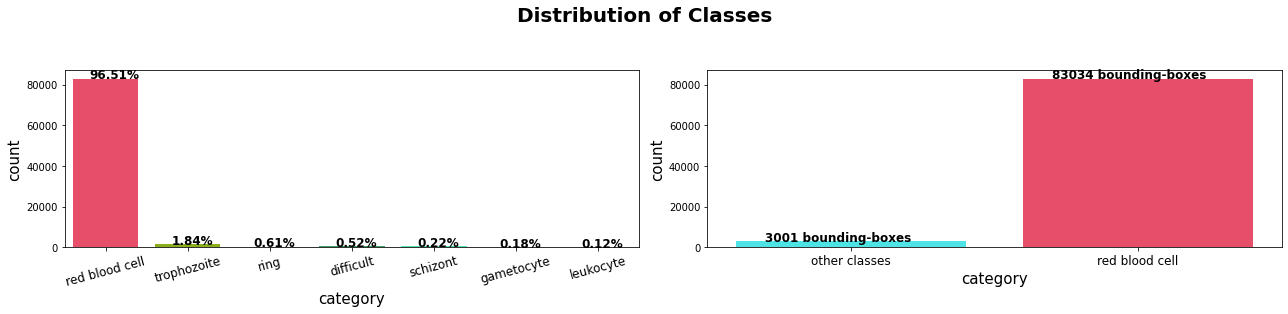

In [26]:
percentages = [c / df.shape[0] * 100 for c in df['category'].value_counts()]
df['Are there red blood cells in the Image?'] = df['category'] == 'red blood cell'

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))
sns.countplot(df['category'], ax=ax[0],  palette=custom_colors[1:])
sns.countplot(df['Are there red blood cells in the Image?'], ax=ax[1], palette=custom_colors)

ax[0].set_xticklabels(df['category'].value_counts().index, fontsize=12, rotation=15)
ax[0].set_xlabel(ax[0].get_xlabel(), fontsize=15)
ax[0].set_ylabel(ax[0].get_ylabel(), fontsize=15)

ax[1].set_xticklabels(['other classes', 'red blood cell'], fontsize=12, rotation=0)
ax[1].set_xlabel('category', fontsize=15)
ax[1].set_ylabel(ax[1].get_ylabel(), fontsize=15)

for percentage, p in zip(percentages, ax[0].patches):
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.2
    y = p.get_y() + p.get_height()
    ax[0].annotate(percentage, (x, y), fontsize=12, fontweight='bold')

for percentage, p in zip([3001, 83034], ax[1].patches):
    percentage = f'{percentage} bounding-boxes'
    x = p.get_x() + p.get_width() / 2 - 0.3
    y = p.get_y() + p.get_height()
    ax[1].annotate(percentage, (x, y), fontsize=12, fontweight='bold')

plt.suptitle("Distribution of Сlasses", y=1.08, fontsize=20, fontweight='bold')
plt.tight_layout()
plt.savefig(f"class_dist.svg", format="svg", bbox_inches='tight', pad_inches=0.2)
plt.savefig(f"class_dist.png", format="png", bbox_inches='tight', pad_inches=0.2)

df.drop(columns=['Are there red blood cells in the Image?'], inplace=True)


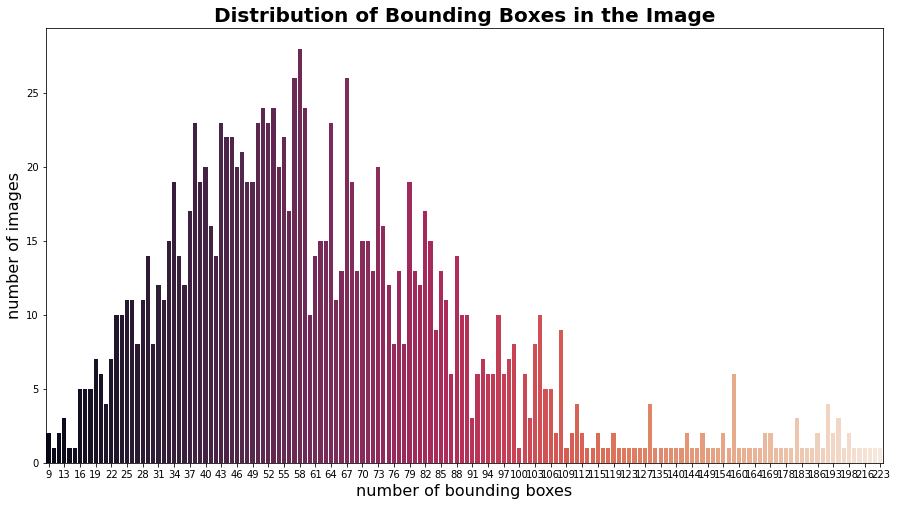

In [27]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.countplot(df.groupby('pathname')['checksum'].count(), ax=ax, palette='rocket')
ax.set_xticks(ax.get_xticks()[::3]);
ax.set_ylabel('number of images', fontsize=16)
ax.set_xlabel('number of bounding boxes', fontsize=16)
ax.set_title("Distribution of Bounding Boxes in the Image", fontsize=20, fontweight='bold');
fig.savefig("bb-dist.svg", format='svg', bbox_inches='tight', pad_inches=0.2)
fig.savefig("bb-dist.png", format='png', bbox_inches='tight', pad_inches=0.2)


In [28]:
df.shape

(86035, 16)

In [29]:
image_dimensions = df.drop_duplicates(subset=['pathname']).groupby(['img_width', 'img_height', 'channels']).count()['pathname'].to_dict()
image_dimensions

{(1600, 1200, 3): 1208, (1944, 1383, 3): 120}

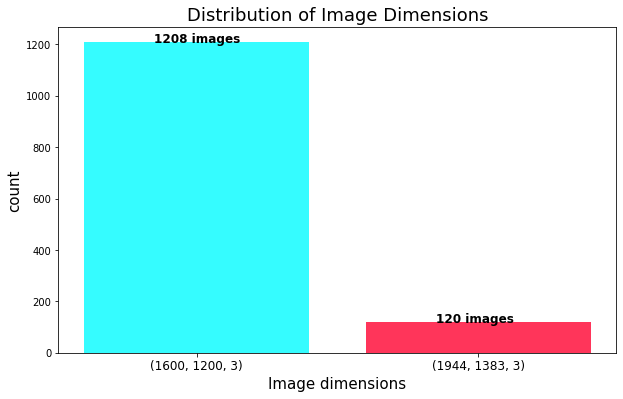

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(np.arange(len(image_dimensions)), image_dimensions.values(), color=custom_colors)
ax.set_xticks(np.arange(len(image_dimensions)))
ax.set_xticklabels(image_dimensions, fontsize=12)
ax.set_xlabel("Image dimensions", fontsize=15)
ax.set_ylabel("count", fontsize=15)
ax.set_title("Distribution of Image Dimensions", fontsize=18)

for percentage, p in zip(image_dimensions.values(), ax.patches):
    percentage = f'{percentage} images'
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage), (x, y), fontsize=12, fontweight='bold')


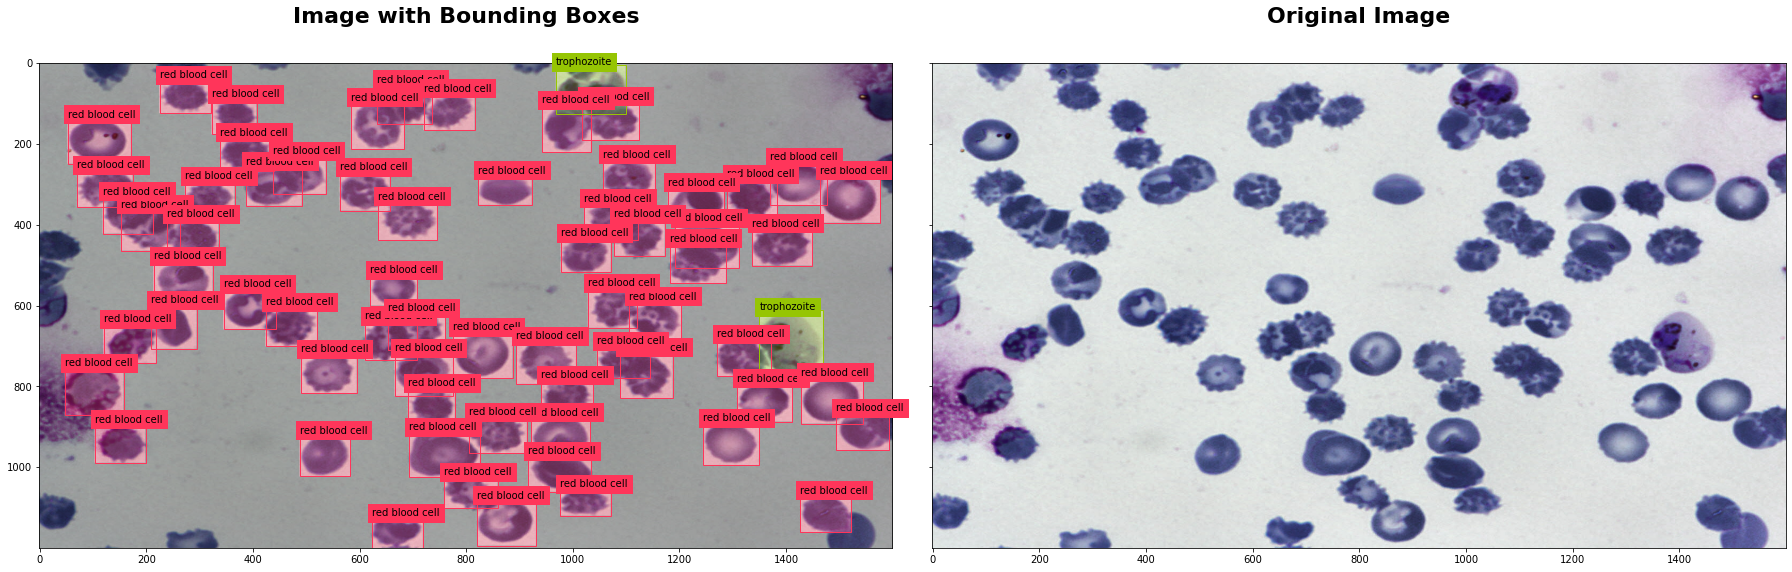

In [31]:
img_path = df["pathname"].sample(1).values[0]

label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}
label2rgb = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), rgbcolors)}

plot_data_example(df, config.root_dir, img_path, colors=label2hex)


# 5. YoloV5

In [32]:
df.head()

,pathname,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,y_center,img_width,img_height,channels,pixels,label
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1440.0,1057.0,1540.0,1158.0,100.0,101.0,1490.0,1107.5,1600,1200,3,5760000,0
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1303.0,868.0,1403.0,971.0,100.0,103.0,1353.0,919.5,1600,1200,3,5760000,0
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,900.0,578.0,1008.0,689.0,108.0,111.0,954.0,633.5,1600,1200,3,5760000,0
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,611.0,304.0,713.0,408.0,102.0,104.0,662.0,356.0,1600,1200,3,5760000,0
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,881.0,198.0,1003.0,312.0,122.0,114.0,942.0,255.0,1600,1200,3,5760000,0


In [33]:
df['w_yolo'] = df[['w', 'img_width']].apply(lambda x: x[0] / x[1], axis=1)
df['h_yolo'] = df[['h', 'img_height']].apply(lambda x: x[0] / x[1], axis=1)
df['x_center_yolo'] = df[['x_center', 'img_width']].apply(lambda x: x[0] / x[1], axis=1)
df['y_center_yolo'] = df[['y_center', 'img_height']].apply(lambda x: x[0] / x[1], axis=1)

In [34]:
yolov5_df = df.copy()
yolov5_df = yolov5_df[yolov5_df["pathname"].apply(lambda x: x[-4:] == '.png')].reset_index(drop=True)
yolov5_df["name"] = yolov5_df["pathname"].apply(lambda x: x.split("/")[-1].split(".")[0])
yolov5_df.head()

,pathname,checksum,category,x_min,y_min,x_max,y_max,w,h,x_center,...,img_width,img_height,channels,pixels,label,w_yolo,h_yolo,x_center_yolo,y_center_yolo,name
0,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1440.0,1057.0,1540.0,1158.0,100.0,101.0,1490.0,...,1600,1200,3,5760000,0,0.06250,0.084167,0.931250,0.922917,8d02117d-6c71-4e47-b50a-6cc8d5eb1d55
1,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,1303.0,868.0,1403.0,971.0,100.0,103.0,1353.0,...,1600,1200,3,5760000,0,0.06250,0.085833,0.845625,0.766250,8d02117d-6c71-4e47-b50a-6cc8d5eb1d55
2,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,900.0,578.0,1008.0,689.0,108.0,111.0,954.0,...,1600,1200,3,5760000,0,0.06750,0.092500,0.596250,0.527917,8d02117d-6c71-4e47-b50a-6cc8d5eb1d55
3,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,611.0,304.0,713.0,408.0,102.0,104.0,662.0,...,1600,1200,3,5760000,0,0.06375,0.086667,0.413750,0.296667,8d02117d-6c71-4e47-b50a-6cc8d5eb1d55
4,images/8d02117d-6c71-4e47-b50a-6cc8d5eb1d55.png,676bb8e86fc2dbf05dd97d51a64ac0af,red blood cell,881.0,198.0,1003.0,312.0,122.0,114.0,942.0,...,1600,1200,3,5760000,0,0.07625,0.095000,0.588750,0.212500,8d02117d-6c71-4e47-b50a-6cc8d5eb1d55


In [35]:
index = list(set(yolov5_df.name))

In [36]:
source = "images"
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
        for name, mini in tqdm(yolov5_df.groupby('name')):
            if name in val_index:
                path2save = 'val2017/'
                #print("val")
            else:
                path2save = 'train2017/'
            if not os.path.exists('convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('convertor/fold{}/labels/'.format(fold)+path2save)
            with open('convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['label','x_center_yolo', 'y_center_yolo', 'w_yolo', 'h_yolo']].astype(float).values
                #print(row)
                #row = row[0:]/1024
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("malaria/{}/{}.png".format(source,name),'convertor/fold{}/images/{}/{}.png'.format(fold,path2save,name))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1208/1208 [00:14<00:00, 83.15it/s]


# Fast RCNN

In [37]:
fastercnn_df = df[['pathname','x_min', 'y_min', 'x_max', 'y_max','w', 'h', 'label', 'category']].copy()
remap_labels = {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}
remap_category = {v:k for v,k in enumerate(fastercnn_df['category'].value_counts().index, 1)} 
fastercnn_df['label'] = fastercnn_df['label'].apply(lambda x: remap_labels[x])      # remap because 0 its bg
fastercnn_df['category'] = fastercnn_df['label'].apply(lambda x: remap_category[x]) # remap because 0 its bg

In [38]:
fastercnn_df.sample()

,pathname,x_min,y_min,x_max,y_max,w,h,label,category
16827,images/4823c1fe-a7f9-4b92-959f-0d9be09cd14b.png,1471.0,349.0,1577.0,439.0,106.0,90.0,1,red blood cell


In [39]:
image_ids = fastercnn_df['pathname'].unique()
train_ids, valid_ids = train_test_split(image_ids,test_size=0.12, shuffle=True, random_state=22)

valid_df = fastercnn_df[fastercnn_df['pathname'].isin(valid_ids)].reset_index(drop=True)
train_df = fastercnn_df[fastercnn_df['pathname'].isin(train_ids)].reset_index(drop=True)

In [40]:
class MalariaDataset(Dataset):

    def __init__(self, dataframe, root_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['pathname'].unique()
        self.df = dataframe
        self.root_dir = root_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['pathname'] == image_id]

        image = cv2.imread(f'{self.root_dir}/{image_id}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values

        area = records['w'].values * records['h'].values
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = records['label'].values
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0).float()
        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [41]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [42]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = MalariaDataset(train_df, config.root_dir, get_train_transform())
valid_dataset = MalariaDataset(valid_df, config.root_dir, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [43]:
images, targets, ids = next(iter(train_data_loader))

In [44]:
label2rgb = {k:v for k, v in 
               zip(fastercnn_df['label'].value_counts().index.tolist(), rgbcolors)}
               
label2category = dict(zip(fastercnn_df['label'].value_counts().index.values, 
                          fastercnn_df['category'].value_counts().index.values))

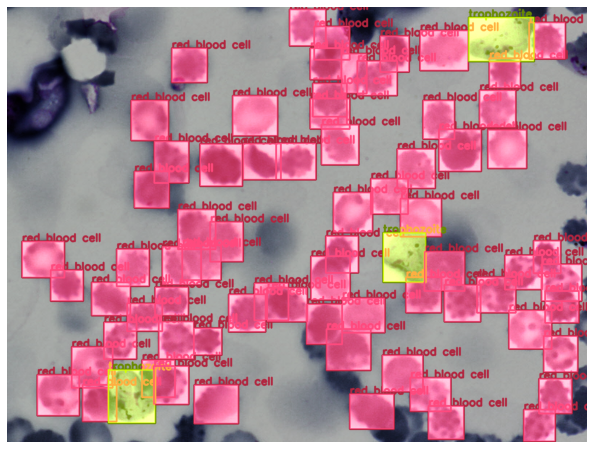

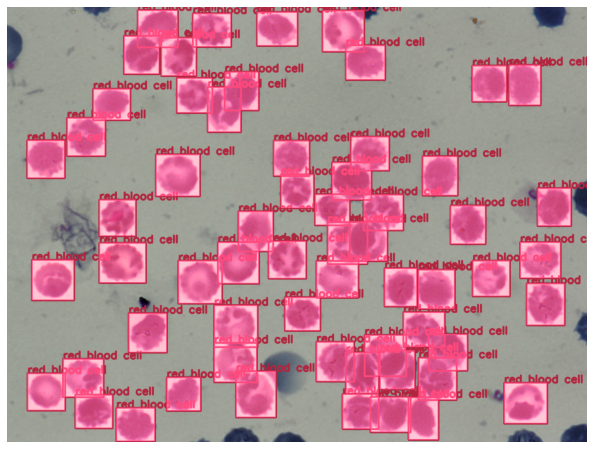

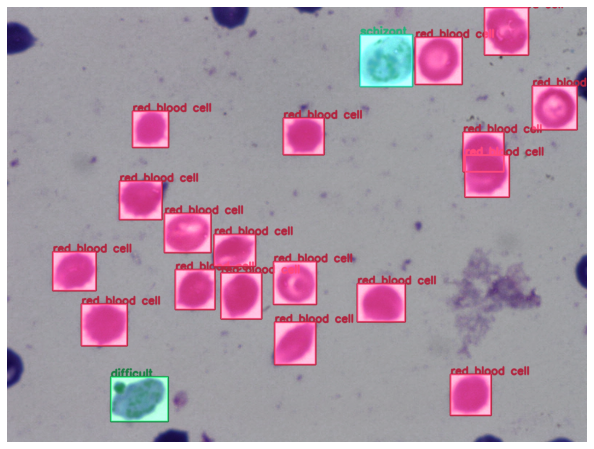

In [45]:
for i_image, i_targets in zip(images[:3], targets[:3]):
    plot_sample(i_image, i_targets['boxes'], i_targets['labels'])

In [47]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

num_classes = 8  # 7 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the trained weights
#model.load_state_dict(torch.load('/content/drive/My Drive/fasterrcnn_resnet50_fpn_80_epoch.pth'))

In [48]:
model.to('cuda')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.004, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min",
                                           patience=3, verbose=True)
#lr_scheduler = None

num_epochs = 3

In [49]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
loss_hist = Averager()
itr = 1
device= 'cuda'
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step(loss_hist.value)

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 1.4429774284362793
Epoch #0 loss: 1.4201167827966261
Iteration #100 loss: 0.8260518312454224
Iteration #150 loss: 0.7810183167457581


In [ ]:
import joblib as jl
jl.dump(model, '/home/project2/weights/model_fastrcnn_ep1.jl')

In [ ]:
torch.save(model.state_dict(), config.fasterrcnn_weights)

In [ ]:
def format_prediction(boxes, scores, labels):
    result = np.zeros((len(boxes), 6))

    for i, (j) in enumerate(zip(scores, boxes, labels)):
        result[i, 0] = j[0]
        result[i, 1] = j[1][0]
        result[i, 2] = j[1][1]
        result[i, 3] = j[1][2]
        result[i, 4] = j[1][3]
        result[i, 5] = j[2]

    return result

In [ ]:
# Load the trained weights
model.load_state_dict(torch.load(config.fasterrcnn_weights))
model.eval()

detection_threshold = 0.5
results = []
ids = []
device = 'cuda'
model.to(device)
for images, targets, image_ids in valid_data_loader:

    images = list(image.to(device) for image in images)
    outputs = model(images)

    for i, image in enumerate(images):

        boxes = outputs[i]['boxes'].data.cpu().numpy()
        scores = outputs[i]['scores'].data.cpu().numpy()
        labels = outputs[i]['labels'].data.cpu().numpy()

        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]
        image_id = image_ids[i]
        
        result = format_prediction(boxes, scores, labels)
        id_ = [image_id] * result.shape[0]
        
        results.append(result)
        ids.append(id_)

In [ ]:
test_df = pd.DataFrame(np.concatenate(results, axis=0), columns=['score', "x_min", "y_min", "x_max", "y_max", 'label'])
test_df['pathname'] = sum(ids, [])
test_df['category'] = test_df['label'].apply(lambda x: label2category[x])
test_df

In [ ]:
test_df.shape

In [ ]:
import joblib as jl

jl.dump(test_df, 'weights/test_df_fastrcnn.jl')
jl.dump(valid_df,'weights/valid_df_fastrcnn.jl')

In [ ]:
test_df['category'].value_counts()

In [ ]:
hex2rgb = lambda hx: (int(hx[1:3],16),int(hx[3:5],16),int(hx[5:7],16))
label2rgb = list(map(hex2rgb, custom_colors))[1:]
label2rgb = {k:v for k, v in 
               zip(fastercnn_df['category'].value_counts().index.tolist(), label2rgb)}
label2hex = {k:v for k, v in 
               zip(fastercnn_df['category'].value_counts().index.tolist(), custom_colors[1:])}

In [ ]:
img_path = test_df["pathname"].sample(1).values[0]

label2hex = {k:v for k, v in 
               zip(df['category'].value_counts().index.tolist(), custom_colors[1:])}

plot_data_example(valid_df, config.root_dir, img_path, colors=label2hex)

In [ ]:
import joblib as jl

test_df_fastrcn = jl.load('weights/test_df_fastrcnn.jl')
valid_df_fastrcnn = jl.load('weights/valid_df_fastrcnn.jl')

test_df_fastrcn.to_excel('weights/test_df_fastrcnn.jl.xlsx')
valid_df_fastrcnn.to_excel('weights/valid_df_fastrcnn.jl.xlsx')
